# Minplus algebra experiment

This code attempts to learn the 8D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()



def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 8

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 143.1909942626953
iteration 0 loss 852.5769653320312


iteration 5000 loss 0.008055861108005047


iteration 10000 loss 0.0027657565660774708


iteration 15000 loss 0.008540318347513676


iteration 20000 loss 0.001286323182284832


iteration 25000 loss 0.0009972560219466686


iteration 30000 loss 0.0008738375618122518


iteration 35000 loss 0.0007819998427294195


iteration 40000 loss 0.0005937704700045288


iteration 45000 loss 0.0005415758932940662


iteration 50000 loss 0.0005189836956560612


iteration 55000 loss 0.00045352219603955746


iteration 60000 loss 0.0004076555196661502


iteration 65000 loss 0.001401293440721929


iteration 70000 loss 0.000401736848289147


iteration 75000 loss 0.0043107373639941216


iteration 80000 loss 0.00033544900361448526


iteration 85000 loss 0.0003155089798383415


iteration 90000 loss 0.0003084121854044497


iteration 95000 loss 0.0003073114494327456


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.00027951793163083494


iteration 105000 loss 0.00022899663599673659


iteration 110000 loss 0.00018992186232935637


iteration 115000 loss 0.00016781847807578743


iteration 120000 loss 0.00015821638226043433


iteration 125000 loss 0.00014101997658144683


iteration 130000 loss 0.00013148288417141885


iteration 135000 loss 0.00012368930038064718


iteration 140000 loss 0.00011701666517183185


iteration 145000 loss 0.00011128247570013627


iteration 150000 loss 0.00010616560757625848


iteration 155000 loss 0.0001016083188005723


iteration 160000 loss 9.77302115643397e-05


iteration 165000 loss 9.408720507053658e-05


iteration 170000 loss 9.114200656767935e-05


iteration 175000 loss 8.785315731074661e-05


iteration 180000 loss 8.514264482073486e-05


iteration 185000 loss 8.269507088698447e-05


iteration 190000 loss 8.027431613299996e-05


iteration 195000 loss 7.812038529664278e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 7.612816261826083e-05


iteration 205000 loss 7.529067079303786e-05


iteration 210000 loss 7.347585778916255e-05


iteration 215000 loss 7.181002729339525e-05


iteration 220000 loss 7.023262151051313e-05


iteration 225000 loss 6.874519749544561e-05


iteration 230000 loss 6.733955524396151e-05


iteration 235000 loss 6.601322093047202e-05


iteration 240000 loss 6.471823144238442e-05


iteration 245000 loss 6.349038449116051e-05


iteration 250000 loss 6.234540342120454e-05


iteration 255000 loss 6.12308649579063e-05


iteration 260000 loss 6.0175494581926614e-05


iteration 265000 loss 5.916517329751514e-05


iteration 270000 loss 5.819209400215186e-05


iteration 275000 loss 5.7271514378953725e-05


iteration 280000 loss 5.6391319958493114e-05


iteration 285000 loss 5.554130257223733e-05


iteration 290000 loss 5.4723503126297146e-05


iteration 295000 loss 5.393428364186548e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 5.319438059814274e-05


iteration 305000 loss 5.2844414312858135e-05


iteration 310000 loss 5.211774259805679e-05


iteration 315000 loss 5.1415110647212714e-05


iteration 320000 loss 5.0725451728794724e-05


iteration 325000 loss 5.006367791793309e-05


iteration 330000 loss 4.942418308928609e-05


iteration 335000 loss 4.880852793576196e-05


iteration 340000 loss 4.821195761905983e-05


iteration 345000 loss 4.77219837193843e-05


iteration 350000 loss 4.7075296606635675e-05


iteration 355000 loss 4.653202631743625e-05


iteration 360000 loss 4.599820385919884e-05


iteration 365000 loss 4.5494231017073616e-05


iteration 370000 loss 4.500805152929388e-05


iteration 375000 loss 4.452628854778595e-05


iteration 380000 loss 4.405546496855095e-05


iteration 385000 loss 4.361095489002764e-05


iteration 390000 loss 4.3174011807423085e-05


iteration 395000 loss 4.274406819604337e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 4.233262734487653e-05


iteration 405000 loss 4.216739034745842e-05


iteration 410000 loss 4.178337985649705e-05


iteration 415000 loss 4.140937016927637e-05


iteration 420000 loss 4.104730760445818e-05


iteration 425000 loss 4.069819624419324e-05


iteration 430000 loss 4.0361635910812765e-05


iteration 435000 loss 4.0034188714344054e-05


iteration 440000 loss 3.971831756643951e-05


iteration 445000 loss 3.940589522244409e-05


iteration 450000 loss 3.909155202563852e-05


iteration 455000 loss 3.877122435369529e-05


iteration 460000 loss 3.8456953916465864e-05


iteration 465000 loss 3.814765659626573e-05


iteration 470000 loss 3.78439508494921e-05


iteration 475000 loss 3.754624412977137e-05


iteration 480000 loss 3.7254099879646674e-05


iteration 485000 loss 3.696812564157881e-05


iteration 490000 loss 3.668719728011638e-05


iteration 495000 loss 3.6411340261111036e-05


L2 loss -- Plot

loss -0.03561079502105713


loss -95.05896759033203


loss -171.6590576171875


loss -236.8137664794922


loss -292.47210693359375


loss -339.42779541015625


loss -378.26904296875


loss -409.72174072265625


loss -435.12255859375


loss -455.85113525390625


loss -472.7354736328125


loss -486.3031005859375


loss -496.9978332519531


loss -505.2407531738281


loss -511.438720703125


loss -515.9749145507812


loss -519.194091796875


loss -521.3946533203125


loss -522.8270263671875


loss -523.7005615234375


loss -524.1918334960938


loss -524.4437255859375


loss -524.5599975585938


loss -524.6072387695312


loss -524.6233520507812


loss -524.627685546875


loss -524.6285400390625


loss -524.6286010742188


loss -524.6286010742188


loss -524.6286010742188


loss -524.6286010742188


loss -524.6286010742188


loss -524.6286010742188


loss -524.6286010742188


loss -524.628662109375


loss -524.6286010742188


loss -524.628662109375


loss -524.6286010742188


loss -524.6286010742188


loss -524.6286010742188


final mse:  2.9059149531107664e-10
max, min: 7.1338215 -8.767094
loss -0.03561079502105713


loss -103.79339599609375


loss -184.00816345214844


loss -252.37315368652344


loss -311.257080078125


loss -361.18408203125


loss -402.41650390625


loss -435.5636901855469


loss -462.02996826171875


loss -483.5462646484375


loss -501.2525939941406


loss -515.7525024414062


loss -527.4540405273438


loss -536.69091796875


loss -543.766357421875


loss -548.9824829101562


loss -552.6550903320312


loss -555.1072998046875


loss -556.6469116210938


loss -557.5445556640625


loss -558.0216674804688


loss -558.247314453125


loss -558.33935546875


loss -558.3704833984375


loss -558.37890625


loss -558.380615234375


loss -558.3807983398438


loss -558.380859375


loss -558.380859375


loss -558.380859375


loss -558.380859375


loss -558.380859375


loss -558.3807983398438


loss -558.380859375


loss -558.380859375


loss -558.380859375


loss -558.380859375


loss -558.3807983398438


loss -558.380859375


loss -558.380859375


final mse:  1.6443671424504203e-10
max, min: 7.983557 -8.53667


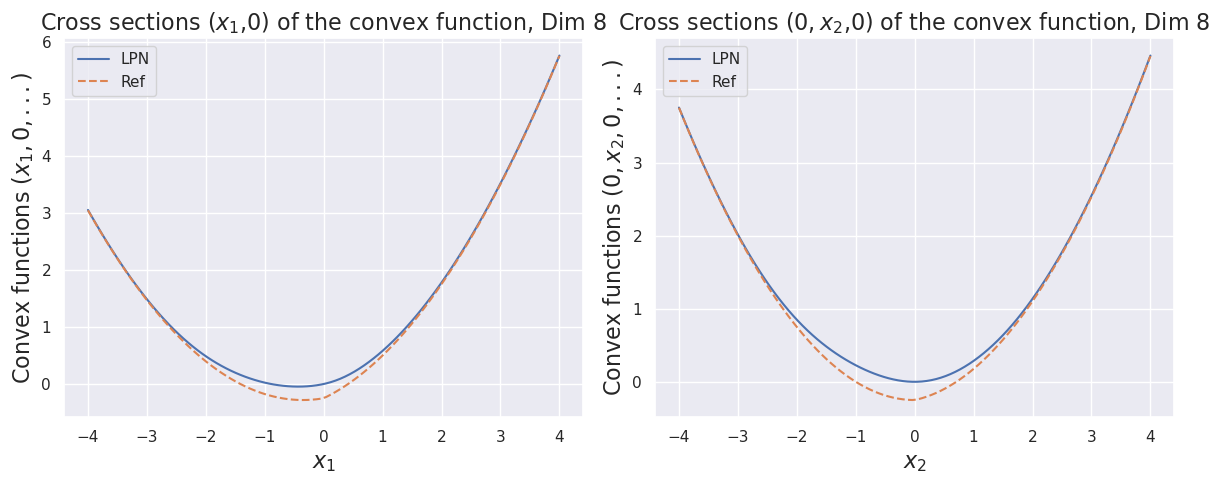

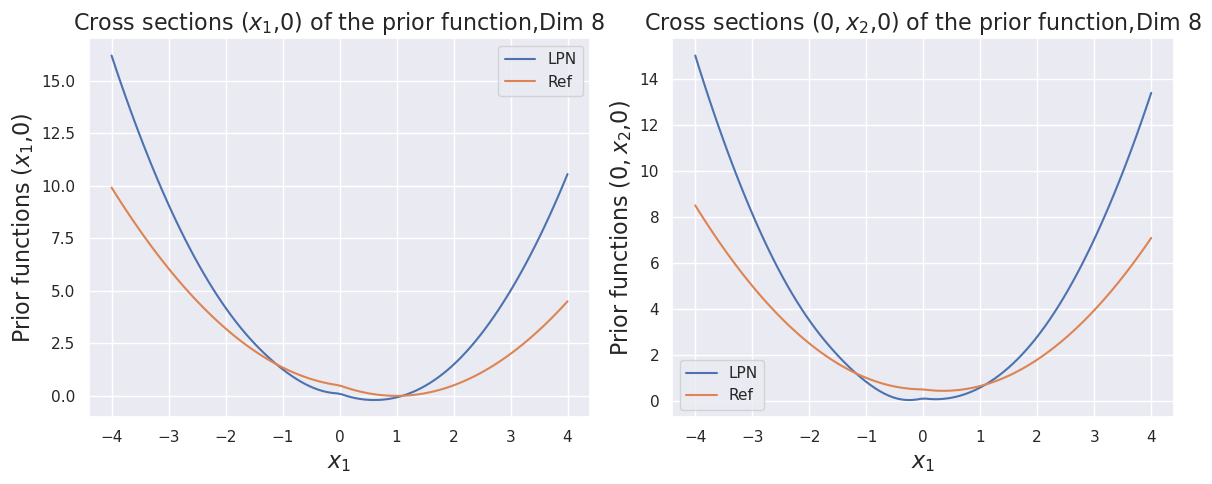

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN  ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) 
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")

iteration 0 loss 135.4390869140625
iteration 0 loss 89.3010025024414


iteration 5000 loss 0.044534552842378616


iteration 10000 loss 0.00683388439938426


iteration 15000 loss 0.003983589354902506


iteration 20000 loss 0.002423732541501522


iteration 25000 loss 0.0018273135647177696


iteration 30000 loss 0.0014652340905740857


iteration 35000 loss 0.0012603449868038297


iteration 40000 loss 0.0010914102895185351


iteration 45000 loss 0.0009715009364299476


iteration 50000 loss 0.0008720540208742023


iteration 55000 loss 0.0007936686160974205


iteration 60000 loss 0.0007284593302756548


iteration 65000 loss 0.0006753827328793705


iteration 70000 loss 0.0006315259961411357


iteration 75000 loss 0.0005914276116527617


iteration 80000 loss 0.0005570309003815055


iteration 85000 loss 0.0005266224034130573


iteration 90000 loss 0.0004995889030396938


iteration 95000 loss 0.00047244722372852266


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.0004506651312112808


iteration 105000 loss 0.0004437936295289546


iteration 110000 loss 0.00042251948616467416


iteration 115000 loss 0.00040602023364044726


iteration 120000 loss 0.00038766124635003507


iteration 125000 loss 0.0003718520456459373


iteration 130000 loss 0.0003578001051209867


iteration 135000 loss 0.00034449665690772235


iteration 140000 loss 0.00033271501888521016


iteration 145000 loss 0.00032155634835362434


iteration 150000 loss 0.00031164867687039077


iteration 155000 loss 0.00030187019729055464


iteration 160000 loss 0.00029319713939912617


iteration 165000 loss 0.0002845574636012316


iteration 170000 loss 0.0002771705621853471


iteration 175000 loss 0.0002692150592338294


iteration 180000 loss 0.00026201194850727916


iteration 185000 loss 0.00025520127383060753


iteration 190000 loss 0.0002486878074705601


iteration 195000 loss 0.00024282802769448608


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.0002363422536291182


iteration 205000 loss 0.00023502937983721495


iteration 210000 loss 0.00022940807684790343


iteration 215000 loss 0.0002241112379124388


iteration 220000 loss 0.00021857506362721324


iteration 225000 loss 0.00021362911502365023


iteration 230000 loss 0.00020894521730951965


iteration 235000 loss 0.00020470998424571007


iteration 240000 loss 0.00020086301083210856


iteration 245000 loss 0.0001967583957593888


iteration 250000 loss 0.00019249571778345853


iteration 255000 loss 0.0001889952109195292


iteration 260000 loss 0.0001857852330431342


iteration 265000 loss 0.00018227574764750898


iteration 270000 loss 0.00017917055811267346


iteration 275000 loss 0.00017622941231820732


iteration 280000 loss 0.00017305432993452996


iteration 285000 loss 0.00017039851809386164


iteration 290000 loss 0.00016777812561485916


iteration 295000 loss 0.00016516688629053533


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.00016288727056235075


iteration 305000 loss 0.00016214435163419694


iteration 310000 loss 0.00015984894707798958


iteration 315000 loss 0.00015755034110043198


iteration 320000 loss 0.00015534754493273795


iteration 325000 loss 0.00015321809041779488


iteration 330000 loss 0.00015114046982489526


iteration 335000 loss 0.00014912687765900046


iteration 340000 loss 0.0001471789728384465


iteration 345000 loss 0.00014536528033204377


iteration 350000 loss 0.00014358805492520332


iteration 355000 loss 0.00014181130973156542


iteration 360000 loss 0.0001400790933985263


iteration 365000 loss 0.00013839264283888042


iteration 370000 loss 0.00013676834350917488


iteration 375000 loss 0.00013519939966499805


iteration 380000 loss 0.00013366815983317792


iteration 385000 loss 0.00013216921070124954


iteration 390000 loss 0.00013071000284980983


iteration 395000 loss 0.00012925235205329955


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.00012781530676875263


iteration 405000 loss 0.00012764228449668735


iteration 410000 loss 0.00012742784747388214


iteration 415000 loss 0.00012721520033665001


iteration 420000 loss 0.00012700408115051687


iteration 425000 loss 0.00012679473729804158


iteration 430000 loss 0.00012658689229283482


iteration 435000 loss 0.00012638134649023414


iteration 440000 loss 0.00012617681932169944


iteration 445000 loss 0.00012597347085829824


iteration 450000 loss 0.00012577191228047013


iteration 455000 loss 0.0001255710667464882


iteration 460000 loss 0.00012537167640402913


iteration 465000 loss 0.00012517336290329695


iteration 470000 loss 0.0001249756896868348


iteration 475000 loss 0.00012477950076572597


iteration 480000 loss 0.000124584068544209


iteration 485000 loss 0.00012438961130101234


iteration 490000 loss 0.0001241962454514578


iteration 495000 loss 0.00012400378182064742


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


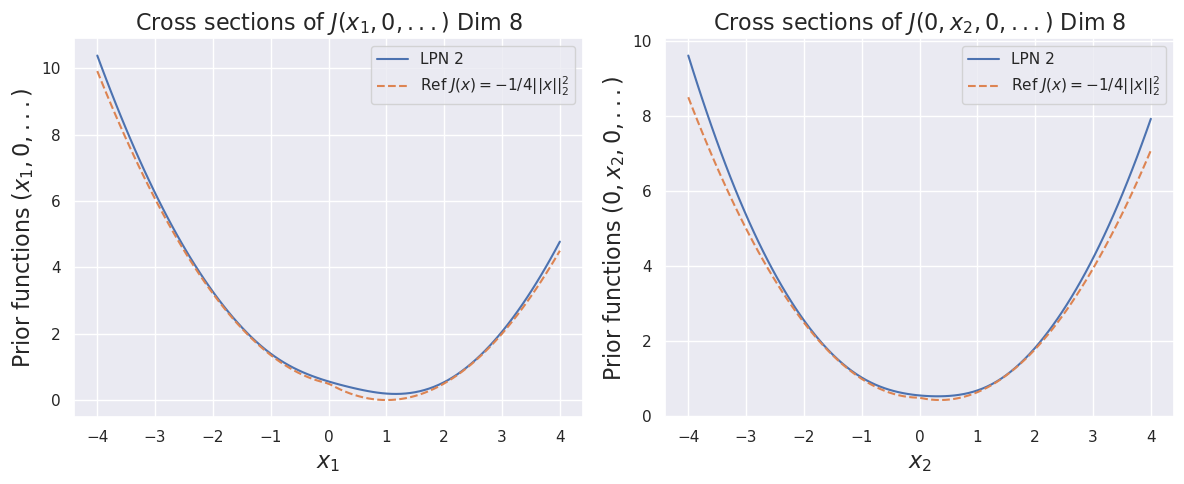

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)